## Machine Learning and Artificial Intelligence, MSc Business Mathematics
## Online Retail Analysis Project
### Angelos Semoglou, s3332318
#### **`Part 3: Association Rules, Recommendation System, Network Graph Analysis of Product Invoices and Recommendations`**

***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import fpgrowth, association_rules

import networkx as nx
from itertools import combinations
import heapq

### Load Previously Processed Data from Part 1

In [2]:
all_data = pd.read_csv('processed_online_retail.csv')

# Convert the 'customer_id' column to string type 
all_data['customer_id'] = all_data['customer_id'].astype(str)   

# Convert the 'invoice_date' column to datetime type
all_data['invoice_date'] = pd.to_datetime(all_data['invoice_date'])

In [3]:
all_data.head(3)

,invoice_id,product_id,description,quantity,invoice_date,price_per_unit,customer_id,country,invoice_amount,year,month,day,hour,season,category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,1,8,Winter,Vintage Design
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,Winter,Urban Home & Jewellery
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,1,8,Winter,Urban Home & Jewellery


***

### Association Rules Mining using FP-Growth Algorithm

#### **Key Metrics in Association Rule Mining**


**Support**
- **Definition**: Support is a measure of how frequently an itemset appears in the dataset. 
- **Calculation**: It is calculated as the proportion of transactions in the dataset that contain the itemset.
- **Formula**: 
  $$
  \text{Support}(X) = \frac{\text{Number of transactions containing } X}{\text{Total number of transactions}}
  $$
- **Interpretation**: Higher support indicates that the itemset is more common in the dataset. It's used to filter out the itemsets that are too infrequent to be of interest.

**Confidence**
- **Definition**: Confidence is a measure of the likelihood that an item Y is purchased when item X is purchased. It represents the percentage of transactions containing X that also contain Y.
- **Calculation**: It is calculated as the ratio of the number of transactions that contain both X and Y to the number of transactions that contain X.
- **Formula**:
  $$
  \text{Confidence}(X \rightarrow Y) = \frac{\text{Support}(X \cup Y)}{\text{Support}(X)}
  $$
- **Interpretation**: Higher confidence indicates a stronger association between items X and Y. It helps in identifying rules that have a high likelihood of occurrence.

**Lift**
- **Definition**: Lift is a measure of how much more likely item Y is purchased when item X is purchased, compared to its general likelihood of being purchased.
- **Calculation**: It is calculated as the ratio of the observed support for X and Y to the expected support if X and Y were independent.
- **Formula**:
  $$
  \text{Lift}(X \rightarrow Y) = \frac{\text{Support}(X \cup Y)}{\text{Support}(X) \times \text{Support}(Y)}
  $$
- **Interpretation**: Lift greater than 1 indicates a positive association between X and Y, meaning they occur together more often than expected by chance. Lift less than 1 indicates a negative association, and lift equal to 1 indicates no association.



In [4]:
class AssociationRules():
    
    def __init__(self, min_support, metric, min_metric_threshold, max_len = None):
        self.min_support = min_support
        self.metric = metric
        self.min_metric_threshold = min_metric_threshold
        self.max_len = max_len

    def generate_rules(self, data, index = 'invoice_id', columns = 'description'):
        
        # Transforming dataset in a form suitable for FPGrowth
        grouped = data.groupby(index)[columns].agg(list)

        one_hot_encoded  = grouped.str.join('|').str.get_dummies()

        product_matrix = one_hot_encoded .astype(bool)

        # Creating frequent itemsets
        frequent_itemsets = fpgrowth(product_matrix,
                                     min_support = self.min_support,
                                     use_colnames = True,
                                     max_len = self.max_len)

        # Extracting Association Rules
        rules = association_rules(frequent_itemsets,
                                  metric = self.metric,
                                  min_threshold = self.min_metric_threshold)
        return rules

In [5]:
minimun_support = 0.005
chosen_metric = 'lift'
minimun_metric_threshold = 1.2
max_item_len = 2

In [6]:
builder = AssociationRules(min_support = minimun_support,
                           metric = chosen_metric,
                           min_metric_threshold = minimun_metric_threshold,
                           max_len = max_item_len)

rules_df = builder.generate_rules(all_data,
                                  index = 'invoice_id',
                                  columns = 'description')


# Convert frozenset to list
rules_df.loc[:, 'antecedents'] = rules_df['antecedents'].apply(lambda x: list(x))
rules_df.loc[:, 'consequents'] = rules_df['consequents'].apply(lambda x: list(x))

rules_df['antecedents'] = rules_df['antecedents'].apply(lambda x : x[0])
rules_df['consequents'] = rules_df['consequents'].apply(lambda x : x[0])

# Select relevant columns
rules_df = rules_df[['antecedents',
                     'consequents',
                     'support',
                     'confidence',
                     'lift']]

In [7]:
display(rules_df.head(3))

,antecedents,consequents,support,confidence,lift
0,HAND WARMER OWL DESIGN,HAND WARMER UNION JACK,0.009658,0.362069,17.652080
1,HAND WARMER UNION JACK,HAND WARMER OWL DESIGN,0.009658,0.470852,17.652080
2,HAND WARMER UNION JACK,HAND WARMER SCOTTY DOG DESIGN,0.008738,0.426009,19.583803


In [8]:
rules_df = rules_df.sort_values(by=['confidence', 'lift'], ascending=[False, False])

In [9]:
display(rules_df.head())

,antecedents,consequents,support,confidence,lift
1151,HERB MARKER THYME,HERB MARKER ROSEMARY,0.008140,0.946524,107.755075
1158,HERB MARKER CHIVES,HERB MARKER PARSLEY,0.007174,0.934132,108.041279
1145,HERB MARKER PARSLEY,HERB MARKER ROSEMARY,0.008048,0.930851,105.970814
1160,HERB MARKER CHIVES,HERB MARKER THYME,0.007128,0.928144,107.922764
1163,HERB MARKER CHIVES,HERB MARKER ROSEMARY,0.007128,0.928144,105.662601


***

### Recommendation Function

In [10]:
def get_recommendations_for_product(product, rules_df, basket_items, top_n=5):
    # Find rules where the product is in the antecedents
    recommendations = rules_df[rules_df['antecedents'] == product]['consequents']
    
    # Filter out items already in the cart
    recommendations = [rec for rec in recommendations if rec not in basket_items]
    
    # Get the top_n recommendations
    top_recommendations = list(pd.Series(recommendations).value_counts().head(top_n).index)
    
    return top_recommendations

In [11]:
def view_basket(user_basket, rules_df):
    print("Items in basket:")
    for item in user_basket:
        print(f"- {item}")
    print("\nRecommendations:")
    
    for item in user_basket:
        recommendations = get_recommendations_for_product(item, rules_df, user_basket)
        if recommendations:
            print(f"\nBecause you liked '{item}', you may like:")
            for rec in recommendations:
                print(f"- {rec}")
        else:
            print(f"\nNo recommendations found for '{item}'")

In [12]:
user_basket = ['HAND WARMER OWL DESIGN',
             'HERB MARKER THYME',
             'ALARM CLOCK BAKELIKE PINK',
             'JAM MAKING SET WITH JARS',
             'JUMBO BAG APPLES',
             'RED KITCHEN SCALES']
             
view_basket(user_basket, rules_df)

Items in basket:
- HAND WARMER OWL DESIGN
- HERB MARKER THYME
- ALARM CLOCK BAKELIKE PINK
- JAM MAKING SET WITH JARS
- JUMBO BAG APPLES
- RED KITCHEN SCALES

Recommendations:

Because you liked 'HAND WARMER OWL DESIGN', you may like:
- HAND WARMER SCOTTY DOG DESIGN
- HAND WARMER BIRD DESIGN
- HAND WARMER UNION JACK
- HAND WARMER RED LOVE HEART
- HAND WARMER RED RETROSPOT

Because you liked 'HERB MARKER THYME', you may like:
- HERB MARKER ROSEMARY
- HERB MARKER PARSLEY
- HERB MARKER BASIL
- HERB MARKER MINT
- HERB MARKER CHIVES 

Because you liked 'ALARM CLOCK BAKELIKE PINK', you may like:
- ALARM CLOCK BAKELIKE RED 
- ALARM CLOCK BAKELIKE GREEN
- ALARM CLOCK BAKELIKE IVORY
- ALARM CLOCK BAKELIKE ORANGE
- ALARM CLOCK BAKELIKE CHOCOLATE

Because you liked 'JAM MAKING SET WITH JARS', you may like:
- JAM MAKING SET PRINTED
- SET OF 3 CAKE TINS PANTRY DESIGN 
- RECIPE BOX PANTRY YELLOW DESIGN
- SET OF 4 PANTRY JELLY MOULDS
- REGENCY CAKESTAND 3 TIER

Because you liked 'JUMBO BAG APPLES', yo

In [13]:
filtered_df_1 = rules_df[rules_df['antecedents'] == 'JAM MAKING SET WITH JARS']
filtered_df_2 = rules_df[rules_df['antecedents'] == 'RED KITCHEN SCALES']
filtered_df_3 = rules_df[rules_df['antecedents'] == 'HAND WARMER OWL DESIGN']

display(filtered_df_1.head(3))
display(filtered_df_2.head(3))
display(filtered_df_3.head(3))

,antecedents,consequents,support,confidence,lift
369,JAM MAKING SET WITH JARS,JAM MAKING SET PRINTED,0.014257,0.322581,7.979742
44,JAM MAKING SET WITH JARS,SET OF 3 CAKE TINS PANTRY DESIGN,0.011359,0.257024,4.588447
1245,JAM MAKING SET WITH JARS,RECIPE BOX PANTRY YELLOW DESIGN,0.008968,0.202914,5.059810


,antecedents,consequents,support,confidence,lift
1206,RED KITCHEN SCALES,IVORY KITCHEN SCALES,0.012325,0.580087,20.117070
1238,RED KITCHEN SCALES,MINT KITCHEN SCALES,0.005657,0.266234,18.495166


,antecedents,consequents,support,confidence,lift
602,HAND WARMER OWL DESIGN,HAND WARMER SCOTTY DOG DESIGN,0.012923,0.484483,22.271867
622,HAND WARMER OWL DESIGN,HAND WARMER BIRD DESIGN,0.012325,0.462069,20.931724
0,HAND WARMER OWL DESIGN,HAND WARMER UNION JACK,0.009658,0.362069,17.652080


***

### Network Graph Analysis for Product Associations

**Product-Level Association Rules**

In [14]:
minimun_support = 0.005
chosen_metric = 'lift'
minimun_metric_threshold = 1.2
max_item_len = 2

builder = AssociationRules(min_support = minimun_support,
                           metric = chosen_metric,
                           min_metric_threshold = minimun_metric_threshold,
                           max_len = max_item_len)

rules_df = builder.generate_rules(all_data,
                                  index = 'invoice_id',
                                  columns = 'description')
# Convert frozenset to list
rules_df.loc[:, 'antecedents'] = rules_df['antecedents'].apply(lambda x: list(x))
rules_df.loc[:, 'consequents'] = rules_df['consequents'].apply(lambda x: list(x))

rules_df['antecedents'] = rules_df['antecedents'].apply(lambda x : x[0])
rules_df['consequents'] = rules_df['consequents'].apply(lambda x : x[0])

rules_df = rules_df[['antecedents',
                     'consequents',
                     'support',
                     'confidence',
                     'lift']]

display(rules_df.head(3))

,antecedents,consequents,support,confidence,lift
0,HAND WARMER OWL DESIGN,HAND WARMER UNION JACK,0.009658,0.362069,17.652080
1,HAND WARMER UNION JACK,HAND WARMER OWL DESIGN,0.009658,0.470852,17.652080
2,HAND WARMER UNION JACK,HAND WARMER SCOTTY DOG DESIGN,0.008738,0.426009,19.583803


**Product Category-Level Association Rules**

In [15]:
# Lower Thresholds on Category Associations to get the general behavior between category purchases
minimun_support = 0.00005
chosen_metric = 'lift'
minimun_metric_threshold = 1
max_item_len = 2

builder_c = AssociationRules(min_support=minimun_support,
                             metric=chosen_metric,
                             min_metric_threshold=minimun_metric_threshold,
                             max_len=max_item_len)

# Generate rules for categories
rules_categories_df = builder_c.generate_rules(all_data, columns='category')

# Convert frozenset to list
rules_categories_df.loc[:, 'antecedents'] = rules_categories_df['antecedents'].apply(lambda x: list(x))
rules_categories_df.loc[:, 'consequents'] = rules_categories_df['consequents'].apply(lambda x: list(x))

rules_categories_df['antecedents'] = rules_categories_df['antecedents'].apply(lambda x : x[0])
rules_categories_df['consequents'] = rules_categories_df['consequents'].apply(lambda x : x[0])

rules_categories_df = rules_categories_df[['antecedents',
                                           'consequents',
                                           'support',
                                           'confidence',
                                           'lift']]

display(rules_categories_df.head(3))

,antecedents,consequents,support,confidence,lift
0,Classic Artistry,Vintage Design,0.612859,0.822745,1.142386
1,Vintage Design,Classic Artistry,0.612859,0.850958,1.142386
2,Accessories,Vintage Design,0.529525,0.780716,1.084029


### Dynamic Product Network Graph Constructor

The GraphBuilder class is designed to create a directed graph that visualizes the relationships between products based on invoice data. This class uses both product and category-level association rules to establish connections, which helps in identifying key influencers within the product network.

This class enables the analysis of product relationships through a network graph, making it easier to understand complex interdependencies in purchasing behavior.

The graph is constructed using both direct product-to-product associations and broader category-to-category relationships as a fallback mechanism.

#### Initialize Nodes
- **Description**: Initializes graph nodes using unique product descriptions from the data.
- **Implementation**: Iterates over unique descriptions and adds each as a node to the graph.

#### Add Edge Attributes
- **Description**: Helper function to add edges between nodes with attributes like confidence, support, and lift.
- **Implementation**: Adds an edge between specified nodes with the provided attributes, defaulting to zero if none provided.

#### Precompute Descriptions to Categories
- **Description**: Caches the category information for each product description for quick access.
- **Implementation**: Creates a dictionary mapping each description to its corresponding category using data from a DataFrame.

#### Build Graph
- **Description**: Constructs the network graph based on direct associations and available category-level data.
- **Implementation**:
  - Iterates over sets of products grouped by invoices.
  - For each product pair, direct product-to-product connections are established if available.
  - If direct connections are absent, attempts to connect products based on category data.

#### Connect Isolated Nodes
- **Description**: Connects nodes that remain isolated after initial graph construction to enhance graph connectivity.
- **Implementation**:
  - Identifies isolated nodes using NetworkX.
  - For each isolated node, assesses category connections based on the highest confidence between the node's category and other categories.
  - Connects each isolated node to the most central node in the category with the highest connection confidence, using degree centrality to determine centrality within that category.


In [16]:
class GraphBuilder():
    def __init__(self, data, rules_df, rules_hfbs_df):
        self.data = data
        self.rules_df = rules_df
        self.rules_categories_df = rules_categories_df
        self.graph = nx.DiGraph()
        self.initialize_nodes()

    def initialize_nodes(self):
        """ Initialize all products as nodes with default attributes. """
        descriptions = self.data['description'].unique()
        for desc in descriptions:
            self.graph.add_node(desc)

    def add_edge_attributes(self, node1, node2, conf, supp, lift):
        """ Helper function to add attributes to edges """
        self.graph.add_edge(node1, node2, confidence=conf or 0, support=supp or 0, lift=lift or 0)

    def precompute_descriptions_to_categories(self):
        """ Cache category information for descriptions to speed up access """
        return self.data.drop_duplicates('description').set_index('description')['category'].to_dict()

    def build_graph(self):
        desc_confidence = {(row['antecedents'], row['consequents']): row for _, row in self.rules_df.iterrows()}
        cat_confidence = {(row['antecedents'], row['consequents']): row for _, row in self.rules_categories_df.iterrows()}
        description_to_category = self.precompute_descriptions_to_categories()

        for products in self.data.groupby('invoice_id')['description'].apply(set):
            for prod_i, prod_j in combinations(products, 2):
                if (prod_i, prod_j) in desc_confidence:
                    row = desc_confidence[(prod_i, prod_j)]
                    self.add_edge_attributes(prod_i, prod_j, row['confidence'], row['support'], row['lift'])
                elif (prod_j, prod_i) in desc_confidence:
                    row = desc_confidence[(prod_j, prod_i)]
                    self.add_edge_attributes(prod_j, prod_i, row['confidence'], row['support'], row['lift'])

        self.connect_isolated_nodes(description_to_category, cat_confidence)

        return self.graph

    def connect_isolated_nodes(self, description_to_category, cat_confidence):
        """ Link isolated nodes to the most central node
        in the category that has the highest confidence metric with the isolated node's own category."""
        category_to_nodes = {}
        for desc, cat in description_to_category.items():
            if cat in category_to_nodes:
                category_to_nodes[cat].append(desc)
            else:
                category_to_nodes[cat] = [desc]

        # Calculate the most central node in each category
        category_to_central_node = {}
        for cat, nodes in category_to_nodes.items():
            subgraph = self.graph.subgraph(nodes)
            centralities = nx.degree_centrality(subgraph)
            most_central_node = max(centralities, key=centralities.get)  # Find the node with the highest centrality
            category_to_central_node[cat] = most_central_node

        # Connect isolated nodes to the most central node of the most connected category
        isolated_nodes = list(nx.isolates(self.graph))
        for node in isolated_nodes:
            node_category = description_to_category.get(node)
            if not node_category:
                continue

            # Determine the category with the highest confidence connection to this node's category
            best_connected_category = None
            highest_confidence = -1
            for (cat1, cat2), props in cat_confidence.items():
                if cat1 == node_category and props['confidence'] > highest_confidence:
                    best_connected_category = cat2
                    highest_confidence = props['confidence']
                elif cat2 == node_category and props['confidence'] > highest_confidence:
                    best_connected_category = cat1
                    highest_confidence = props['confidence']

            # Connect the node to the central node of the best connected category
            if best_connected_category and best_connected_category in category_to_central_node:
                central_node = category_to_central_node[best_connected_category]
                self.add_edge_attributes(node, central_node, conf=0.1, supp=0.1, lift=1.0)

In [17]:
builder = GraphBuilder(all_data, rules_df, rules_categories_df)
graph = builder.build_graph()

In [18]:
G = graph

Ensure that the Graph does not have isolated nodes

In [19]:
def print_isolated_nodes(g):
   
    isolated_nodes = list(nx.isolates(g))
    
    if not isolated_nodes:
        print("No isolated nodes found in the graph.")
    else:
        print(f"Isolated nodes found: {len(isolated_nodes)}")
        print(f"Isolated nodes: {isolated_nodes}")
    
    return isolated_nodes

isolated_nodes = print_isolated_nodes(G)

No isolated nodes found in the graph.


***

### Personalized PageRank Recommendations

Personalized PageRank adapts the original PageRank algorithm to focus on a specific node (product), emphasizing paths that start from this node. 
This provides a personalized ranking of all nodes in the graph based on their relevance to the starting node.

By tailoring the PageRank to a starting node, we ensure that the recommendations are highly relevant to the user's current interest or recent activity.

Personalized PageRank considers the entire graph's structure, which helps identify both direct and indirect relationships between products. This holistic view can reveal less obvious but potentially valuable recommendations.

In [20]:
def personalized_pagerank_recommendations(G, start_node, alpha=0.85):
    if start_node not in G:
        print(f"Error: {start_node} does not exist in the graph.")
        return pd.DataFrame()  # Return an empty DataFrame if the node does not exist
    
    # Compute the personalized PageRank
    pr = nx.pagerank(G, alpha=alpha, personalization={start_node: 1})
    
    # Sort nodes by PageRank score
    ranked_nodes = sorted(pr.items(), key=lambda x: x[1], reverse=True)
    
    # Filter out the start node if it appears in the recommendations
    recommendations = [(node, score) for node, score in ranked_nodes if node != start_node]
    
    # Recommendations to a DataFrame
    recommendations_df = pd.DataFrame(recommendations, columns=['Node', 'PageRank'])
    
    return recommendations_df

**Example**

In [21]:
start_node = 'LUNCH BAG RED RETROSPOT' 
recommendations_df = personalized_pagerank_recommendations(G, start_node)

print("Top 10 personalized PageRank recommendations:")
print(recommendations_df.head(10))

Top 10 personalized PageRank recommendations:
                                 Node  PageRank
0             JUMBO BAG RED RETROSPOT  0.026173
1             LUNCH BAG  BLACK SKULL.  0.022540
2  WHITE HANGING HEART T-LIGHT HOLDER  0.022146
3                 LUNCH BAG CARS BLUE  0.019744
4             JUMBO BAG PINK POLKADOT  0.019238
5                    JUMBO BAG APPLES  0.018663
6             LUNCH BAG PINK POLKADOT  0.017969
7         RED RETROSPOT CHARLOTTE BAG  0.016837
8              LUNCH BAG SUKI DESIGN   0.016281
9              JUMBO BAG VINTAGE LEAF  0.016109


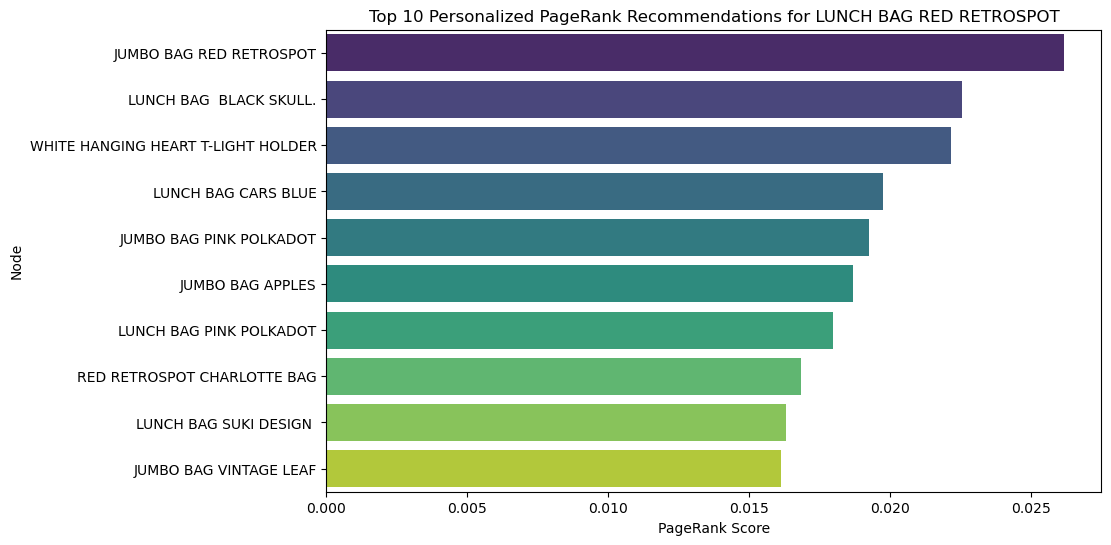

In [22]:
top_10_recommendations = recommendations_df.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='PageRank', y='Node', data=top_10_recommendations, palette='viridis')
plt.xlabel('PageRank Score')
plt.ylabel('Node')
plt.title(f'Top 10 Personalized PageRank Recommendations for {start_node}')
plt.show()

***

### A* Search Algorithm Recommendations

A* search algorithm finds the shortest path between nodes in a graph. In this context, the "shortest path" is based on the confidence of co-purchase edges, with higher confidence leading to lower costs.

The path offers a personalized sequence of products that a customer is likely to purchase. This journey can make the shopping experience more engaging.

In [23]:
def heuristic(graph, current, neighbor):
    """Heuristic based on the confidence attribute of the edge, used as inverse to prioritize high confidence."""
    if neighbor in graph[current]:
        return 1 / graph[current][neighbor].get('confidence', 1)
    return 1  # Default heuristic value if no confidence info

def a_star_recommendation(graph, start, goal=None, limit=10):
    """A* algorithm for product recommendation using confidence as both cost and heuristic."""
    pq = []  # Priority queue for A* search
    heapq.heappush(pq, (0, start, [start]))  # (estimated_cost, current_node, path)
    visited = set()

    while pq:
        estimated_cost, current, path = heapq.heappop(pq)
        if current in visited:
            continue
        visited.add(current)

        # Reach the limit of path length or found the goal
        if current == goal or len(path) >= limit:
            print(f"Recommended path: {path} with estimated cost: {estimated_cost}")
            return path

        for neighbor in graph.neighbors(current):
            if neighbor in visited:
                continue

            edge_confidence = graph[current][neighbor].get('confidence', 0.1) 
            new_cost = estimated_cost - edge_confidence  # Higher confidence = lower "cost"
            new_path = path + [neighbor]

            # Estimate future cost (heuristic)
            future_cost = heuristic(graph, current, neighbor)
            total_estimated_cost = new_cost + future_cost

            heapq.heappush(pq, (total_estimated_cost, neighbor, new_path))

    print("No path found after reaching the specified limit")
    return []

In [24]:
def visualize_path(graph, path):
    subgraph = graph.subgraph(path)
    pos = nx.spring_layout(subgraph)
    plt.figure(figsize=(22, 14))
    
    nx.draw_networkx_nodes(subgraph, pos, nodelist=path, node_color='orange', node_size=3000)
    nx.draw_networkx_labels(subgraph, pos, labels={node: node for node in path}, font_size=12, font_color='black')
    
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(subgraph, pos, edgelist=path_edges, edge_color='orange', width=2)
    
    plt.title(f"Recommended Path: {' -> '.join(path)}")
    plt.show()

**Example**

In [25]:
start_node = 'LUNCH BAG RED RETROSPOT'
goal_node = 'HAND WARMER OWL DESIGN'
path = a_star_recommendation(G, start_node, goal_node)

Recommended path: ['LUNCH BAG RED RETROSPOT', 'LUNCH BAG VINTAGE DOILY ', 'JUMBO BAG VINTAGE DOILY ', "JUMBO BAG 50'S CHRISTMAS ", "PAPER CHAIN KIT 50'S CHRISTMAS ", 'HAND WARMER OWL DESIGN'] with estimated cost: 20.90331324368326


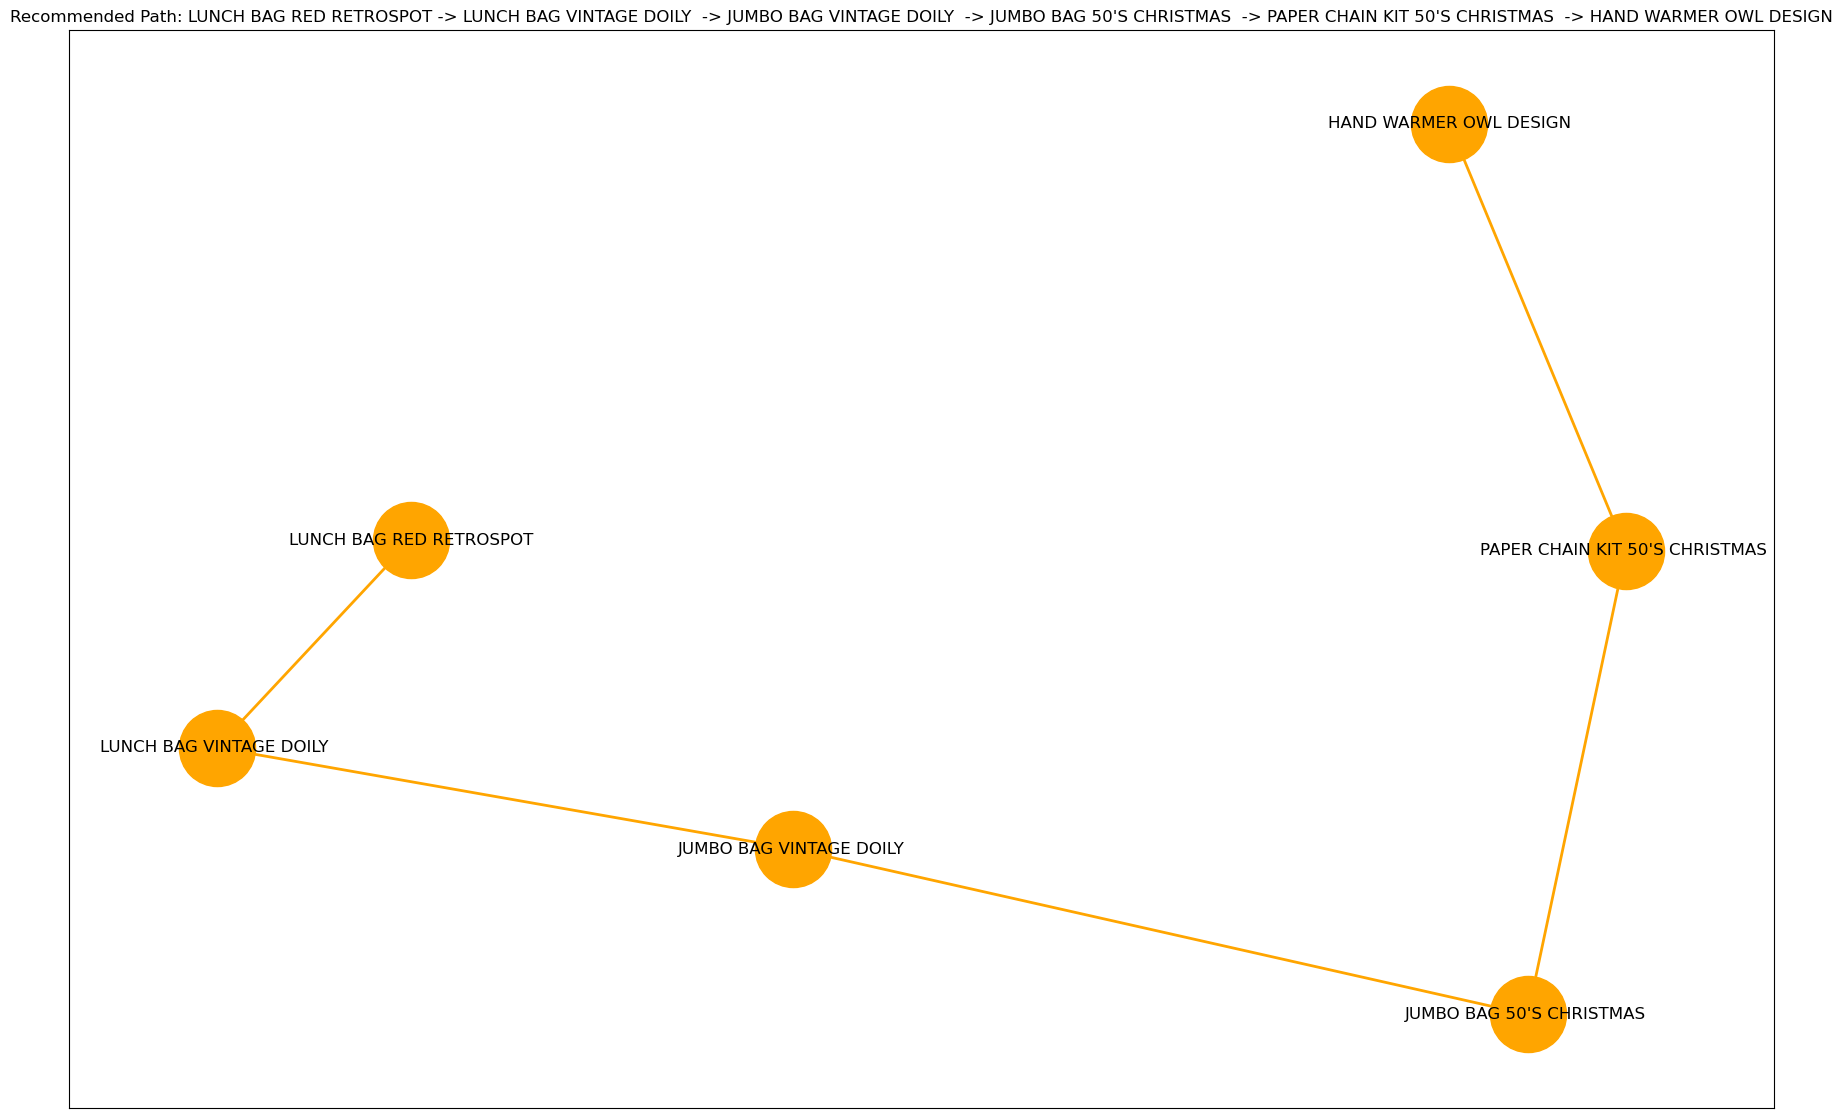

In [26]:
visualize_path(G, path)